In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
import pynini

from torch.utils.data import DataLoader
from model_util import SequenceDataset, DistilBertData

from model_util.distillbert_for_language_model import DistilBertForTokenClassification

import numpy as np
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

#PROBLEM = "04.03.TLT.2.1.2" #"04.03.TSL.2.1.8" # "04.04.SL.2.1.8" # "16.16.SL.2.1.9"
PROBLEM = "16.16.SL.2.1.9"
MAX_STRING_LENGTH = 29 # must be same as in training script
BSIZE = 128

ACCEPTOR_NAME = "distilbert_problem_{}_1.pk".format(PROBLEM) # prefix of model name
MODEL_NAME = ACCEPTOR_NAME+".finetuned" # gives us the type of model

DO_TSNE = False 

DATASET_CONTAINER_PATH = "dataset_problem_{}.pk".format(PROBLEM) # where to save dataset metadata 
RESULTS_PATH = "../trained_models/"

TRAIN_DATA_PATH = "../data/abbadingo/Mid/{}_Train.txt.dat".format(PROBLEM)
TEST_DATA_PATH = "../data/abbadingo/Mid/{}_TestSR.txt.dat".format(PROBLEM)

FST_PATH = "../data/languages/fst"

DEVICE = "cpu"

/home/robert/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/robert/.local/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [2]:
train_dataset = SequenceDataset(TRAIN_DATA_PATH, maxlen=MAX_STRING_LENGTH)
train_dataset.initialize(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))
train_dataset.encode_sequences()

del train_dataset.one_hot_seq
del train_dataset.one_hot_seq_sr
del train_dataset.ordinal_seq_sr

Alphabet size:  16
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'a', 'k', 'd', 'k', 'l', 'a', 'e', 'm', 'o', 'b', 'l', 'k', 'a', 'p', 'i', 'i', 'b'], ['a', 'a', 'a', 'm', 'm', 'n', 'j', 'h', 'h', 'c', 'p', 'l', 'o', 'n', 'f', 'i', 'e', 'a', 'n', 'b'], ['a', 'a', 'b', 'e', 'f', 'n', 'd', 'm', 'k', 'p', 'b', 'n', 'l', 'i', 'p', 'k', 'f', 'm', 'b', 'b']]
The symbol dictionary: {'a': 0, 'k': 1, 'd': 2, 'l': 3, 'e': 4, 'm': 5, 'o': 6, 'b': 7, 'p': 8, 'i': 9, 'n': 10, 'j': 11, 'h': 12, 'c': 13, 'f': 14, 'g': 15}


In [3]:
train_dataset.SOS, train_dataset.EOS

(16, 17)

## Get the model

In [4]:
def make_dict(**kwargs):
    return kwargs

init_dict = make_dict( # WARNING: must be same as in training file
    # vocab_size=train_dataset.alphabet_size+3,
    vocab_size=train_dataset.alphabet_size+5,
    num_labels=train_dataset.alphabet_size+5,
    max_position_embeddings=train_dataset.maxlen+2,
    sinusoidal_pos_embds=True,
    use_pos_embds=True,
    
    n_layers=4,
    n_heads=12,
    # dim=train_dataset.alphabet_size*2,
    dim = 96,
    hidden_dim = 96,
    # hidden_dim=train_dataset.alphabet_size*2,
    activation="gelu",
    dropout=0.1,
    attention_dropout=0.1,
    seq_classif_dropout=0.2,
    PAD_TOKEN_id=train_dataset.PAD
)

model = DistilBertForTokenClassification(transformers.DistilBertConfig(**init_dict))

#torch.save(model.state_dict(), )
model.load_state_dict(torch.load(os.path.join(RESULTS_PATH, MODEL_NAME), map_location=torch.device('cpu')))
#model = torch.load(os.path.join("..", "trained_models", "model_{}.pk".format(PROBLEM)))

<All keys matched successfully>

## Get the state machine

In [5]:
the_fsa = pynini.Fst.read(os.path.join(FST_PATH, "{}.fst".format(PROBLEM)))
states = [q for q in the_fsa.states()]
initial_state = the_fsa.start()
initial_state, states

(0, [0, 1, 2])

In [6]:
symbol_to_char = dict(the_fsa.input_symbols())
char_to_symbol = {v: k for k, v in symbol_to_char.items()}

char_to_symbol

{'<EPS>': 0,
 'a': 97,
 'b': 98,
 'c': 99,
 'd': 100,
 'e': 101,
 'f': 102,
 'g': 103,
 'h': 104,
 'i': 105,
 'j': 106,
 'k': 107,
 'l': 108,
 'm': 109,
 'n': 110,
 'o': 111,
 'p': 112}

In [7]:
arcs = {q: {symbol_to_char[a.ilabel]: a.nextstate for a in the_fsa.arcs(q)} for q in states}
arcs

{0: {'a': 1},
 1: {'a': 1,
  'c': 1,
  'd': 1,
  'e': 1,
  'f': 1,
  'g': 1,
  'h': 1,
  'i': 1,
  'j': 1,
  'k': 1,
  'l': 1,
  'm': 1,
  'n': 1,
  'o': 1,
  'p': 1,
  'b': 2},
 2: {'a': 1,
  'c': 1,
  'd': 1,
  'e': 1,
  'f': 1,
  'g': 1,
  'h': 1,
  'i': 1,
  'j': 1,
  'k': 1,
  'l': 1,
  'm': 1,
  'n': 1,
  'o': 1,
  'p': 1,
  'b': 2}}

## Set up dataset

In [8]:
def construct_attn_mask(lengths, maxlen):
    """
    Lengths is a list. For each sequence in input_ids it gives the length
    """
    res = torch.ones((len(lengths), maxlen))
    for i, l in enumerate(lengths):
        res[i, l:] = 0
    return res

def make_tensor_causal_masks(words:torch.Tensor):
    masks = (words != PAD_TOKEN) # 1 : pass, 0 : blocked
    b,l = masks.size()
    x = torch.einsum("bi,bj->bij",masks,masks)
    # Mask with lower triangle including diagonal -> causal mask
    x *= torch.ones(l,l, dtype=torch.bool, device=x.device).tril() 
    x += torch.eye(l,dtype=torch.bool, device=x.device)
    return x.type(torch.int8)

def get_forward_dict(x, y, mask, output_attentions=False):
    forward_dict = make_dict(
        input_ids=x, # the training data
        labels=y, # the training labels
        attention_mask=mask, # TODO: we can do this to improve the models I suppose
        head_mask=None,
        output_attentions=output_attentions,
        output_hidden_states=False,
        return_dict=True,
    )
    return forward_dict

In [9]:
test_dataset = SequenceDataset(TEST_DATA_PATH, maxlen=MAX_STRING_LENGTH)
test_dataset.initialize(os.path.join(RESULTS_PATH, DATASET_CONTAINER_PATH))
test_dataset.encode_sequences()

del test_dataset.one_hot_seq
del test_dataset.one_hot_seq_sr
del test_dataset.ordinal_seq_sr

test_input_ids = torch.cat(list(torch.unsqueeze(x, 0) for x in test_dataset.ordinal_seq))
test_labels = test_dataset.labels
test_attn_mask = construct_attn_mask(test_dataset.sequence_lengths, test_dataset.maxlen)

test_data = DistilBertData(test_input_ids, test_labels, test_attn_mask)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=BSIZE)

PAD_TOKEN = test_dataset.PAD
EOS_TOKEN = test_dataset.EOS

pos_flags = torch.tensor(test_labels) == 0

Alphabet size:  16
Sequences loaded. Some examples: 
[['a', 'a', 'a', 'c', 'j', 'c', 'g', 'p', 'n', 'c', 'n', 'l', 'p', 'p', 'a', 'm', 'l', 'l', 'f', 'b'], ['a', 'a', 'a', 'm', 'j', 'h', 'g', 'e', 'o', 'f', 'g', 'm', 'f', 'd', 'a', 'h', 'l', 'a', 'f', 'b'], ['a', 'a', 'b', 'e', 'i', 'd', 'k', 'f', 'm', 'n', 'e', 'f', 'h', 'k', 'k', 'a', 'l', 'n', 'b', 'b']]
The symbol dictionary: {'a': 0, 'k': 1, 'd': 2, 'l': 3, 'e': 4, 'm': 5, 'o': 6, 'b': 7, 'p': 8, 'i': 9, 'n': 10, 'j': 11, 'h': 12, 'c': 13, 'f': 14, 'g': 15}


## Get test attentions and outputs

## Hint: We only use the first (or one) attention output here.

In [10]:
test_attn = None
test_predictions = None

attn_idx = 0 # the index of the attention that we want to use for our analysis

with torch.no_grad():
    model.eval()
    for j, (x_batch, y_batch, _) in enumerate(test_dataloader):
        x_batch = x_batch.to(DEVICE)
        mask_batch = make_tensor_causal_masks(x_batch)
        y_batch = torch.argmax(y_batch, dim=1).to(DEVICE)

        outputs = model(input_ids = x_batch, attention_mask = mask_batch, return_dict=True, output_attentions=True)

        attn_concate = np.concatenate([outputs["attentions"][i].detach().numpy() for i in range(len(outputs["attentions"]))], axis=-1)
        if test_attn is None:
            test_attn = attn_concate
            print(attn_concate.shape)
        else: 
            test_attn = np.vstack((test_attn, attn_concate))
        
        preds = torch.zeros_like(y_batch)
        for i in range(x_batch.size(0)):
            last_pos = torch.where(x_batch[i] == EOS_TOKEN)[0][0]
            preds[i] = torch.argmax(outputs.logits[i, last_pos])
                
        # outputs.logits shape: (batch_size, seq_len, label_size)
        if(outputs.logits.size(-1) > PAD_TOKEN + 1):
            preds = preds - PAD_TOKEN - 1
            
        #isCorrect += (y_batch == preds).tolist()
        #print(preds, y_batch)
        #break
        if test_predictions is None:
            test_predictions = preds.numpy()
            print(test_predictions.shape)
        else:
            test_predictions = np.concatenate((test_predictions, preds.numpy()), axis=-1)

test_predictions.shape, test_attn.shape

(128, 12, 31, 124)
(128,)


((10000,), (10000, 12, 31, 124))

## Get the sequence of states for each sequence

In [11]:
def convert_ids_to_chars(mapping, tensor_1d, eos_symbol: int = None):
    """
    Converts the input_ids tensor to a list representing the original input.
    Mapping is dict mapping int to str/char.

    tensor_1d: The sequence as provided to the model.
    """
    res = list()
    eos_idx = None
    try:
        tensor_1d = tensor_1d.detach().numpy()
    except:
        tensor_1d = tensor_1d.numpy()
    for i, x in enumerate(tensor_1d):
        if eos_symbol is not None and x==eos_symbol:
            eos_idx = i
        res.append(mapping[x])
    print("The original sequence: {}".format(" ".join(res)))
    return res, eos_idx

symbol_dict = {k: v for k, v in test_dataset.symbol_dict.items()}
symbol_dict["<SOS>"] = train_dataset.SOS
symbol_dict["<EOS>"] = train_dataset.EOS
symbol_dict["<PAD>"] = train_dataset.PAD

symbol_dict

{'a': 0,
 'k': 1,
 'd': 2,
 'l': 3,
 'e': 4,
 'm': 5,
 'o': 6,
 'b': 7,
 'p': 8,
 'i': 9,
 'n': 10,
 'j': 11,
 'h': 12,
 'c': 13,
 'f': 14,
 'g': 15,
 '<SOS>': 16,
 '<EOS>': 17,
 '<PAD>': 18}

In [12]:
int_to_char_map = {v: k for k, v in symbol_dict.items()}

def map_to_chars(sequences, int_to_char_map):
    res = list()
    for i, seq in enumerate(sequences):
        sequence = list()
        for j, s in enumerate(seq):
            sequence.append(int_to_char_map[s])
        res.append(sequence)
    return res

char_sequences = map_to_chars(test_input_ids.detach().numpy(), int_to_char_map)
char_sequences[0]

['<SOS>',
 'a',
 'a',
 'a',
 'c',
 'j',
 'c',
 'g',
 'p',
 'n',
 'c',
 'n',
 'l',
 'p',
 'p',
 'a',
 'm',
 'l',
 'l',
 'f',
 'b',
 '<EOS>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [13]:
def extract_state_sequences(char_sequences, initial_state, arcs):
    """
    Char sequences is list of list. Returns a list of lists containing 
    state reached after each outgoing symbol.
    """
    res = list()
    for sequence in char_sequences:
        q = None
        trace = list()
        for symbol in sequence:
            if symbol=="<SOS>":
                q = initial_state
            elif symbol=="<EOS>":
                q = -1 # we are interested in this embedding, too
            elif symbol=="<PAD>":
                break
            elif q==-2: # we are in the sink state
                q = -2
            elif symbol not in arcs[q]:
                q = -2 # automaton cannot be parsed, hence trace not accepting, hence we are in sink state
            else:
                q = arcs[q][symbol]
            trace.append(q)
        res.append(trace)
    return res

state_sequences = extract_state_sequences(char_sequences, initial_state, arcs)
state_sequences[:5], char_sequences[:5]

([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, -1],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, -1],
  [0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, -1],
  [0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, -1],
  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, -1]],
 [['<SOS>',
   'a',
   'a',
   'a',
   'c',
   'j',
   'c',
   'g',
   'p',
   'n',
   'c',
   'n',
   'l',
   'p',
   'p',
   'a',
   'm',
   'l',
   'l',
   'f',
   'b',
   '<EOS>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>'],
  ['<SOS>',
   'a',
   'a',
   'a',
   'm',
   'j',
   'h',
   'g',
   'e',
   'o',
   'f',
   'g',
   'm',
   'f',
   'd',
   'a',
   'h',
   'l',
   'a',
   'f',
   'b',
   '<EOS>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>',
   '<PAD>'],
  ['<SOS>',
   'a',
   'a',
   'b',
   'e',
   'i',
   'd'

## Map the sequences of states along with the embeddings, check if you get meaningful output here

In [14]:
def filter_attention(sequences, attentions, lengths, state_sequences):
    """
    Gets the attention etc. into a good shape. We discard everything padded here.

    sequences: np.array
    attentions: np.array
    lengths: list with the lengths.
    states: A list of states visited. In accordance with sequences
    """
    attn_stack = None
    symbols = list()
    visited_states = list()
    
    for attn, seq, l, state_s in zip(attentions, sequences, lengths, state_sequences):
        if len(attn.shape) > 2:            
            # we have multiple heads
            attn = np.mean(attn, axis=0) # (seq_length, seq_length)
        attn = attn[:l]
        attn_stack = attn if attn_stack is None else np.vstack((attn_stack, attn))

        seq = list(seq[:l])
        #print(seq)
        symbols.extend(seq)
        qs = list(state_s[:l])
        visited_states.extend(qs)

    return attn_stack, symbols, visited_states

In [15]:
attn_filtered, symbols_filtered, states_filtered = filter_attention(
                                                               test_input_ids.detach().numpy(), 
                                                               test_attn,
                                                               list(np.array(test_dataset.sequence_lengths)),
                                                               state_sequences
                                                               )

In [16]:
attn_filtered.shape, len(symbols_filtered), len(states_filtered)

((265000, 124), 265000, 265000)

<Axes: >

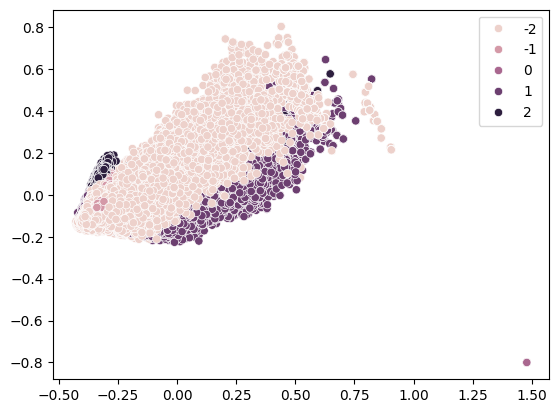

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered)
sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered))

## Look at only stuff that you care about

In [18]:
no_eos_idxs = np.where(np.array(states_filtered)!=-1)[0]
no_sink_state_idxs = np.where(np.array(states_filtered)!=-2)[0]

idxs_under_investigation = list(set(list(no_eos_idxs)).intersection(set(list(no_sink_state_idxs))))

<Axes: >

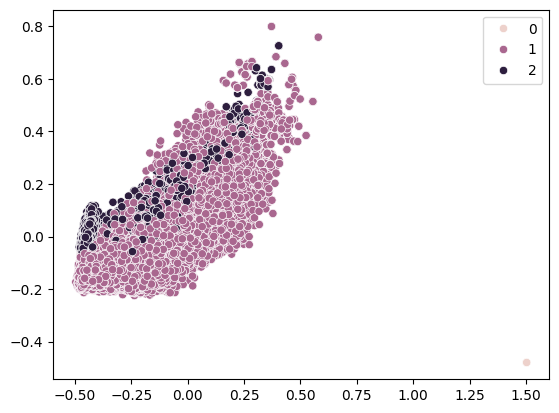

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

In [20]:
if DO_TSNE:
    from sklearn.manifold import TSNE
    
    tsne = TSNE()
    attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])

In [21]:
if DO_TSNE:
    states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
    zero_idx = np.where(states_under_investigation==0)[0]
    one_idx = np.where(states_under_investigation==1)[0]
    two_idx = np.where(states_under_investigation==2)[0]
    
    sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=states_under_investigation[one_idx], palette="rocket")
    sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=states_under_investigation[zero_idx], palette="mako")
    sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=states_under_investigation[two_idx])

from sklearn.manifold import TSNE

tsne = TSNE()
attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

## What about when we only look at positive predicted strings?

In [22]:
POSITIVE_LABEL = train_dataset.label_dict["A"]
NEGATIVE_LABEL = train_dataset.label_dict["R"]

positive_prediction_idxs = np.where(test_predictions==POSITIVE_LABEL)[0]
positive_label_idxs = np.where(np.array(test_labels)==POSITIVE_LABEL)[0]

positive_prediction_idxs

array([   0,    1,    2, ..., 9510, 9522, 9523])

In [23]:
attn_filtered, symbols_filtered, states_filtered = filter_attention(
                                                               test_input_ids[positive_prediction_idxs].detach().numpy(), 
                                                               test_attn[positive_prediction_idxs],
                                                               list(np.array(test_dataset.sequence_lengths)[positive_prediction_idxs]),
                                                               [state_sequences[i] for i in positive_prediction_idxs]
                                                               )

In [24]:
attn_filtered.shape, len(symbols_filtered), len(states_filtered)

((132993, 124), 132993, 132993)

In [25]:
no_eos_idxs = np.where(np.array(states_filtered)!=-1)[0]
no_sink_state_idxs = np.where(np.array(states_filtered)!=-2)[0]

idxs_under_investigation = list(set(list(no_eos_idxs)).intersection(set(list(no_sink_state_idxs))))

<Axes: >

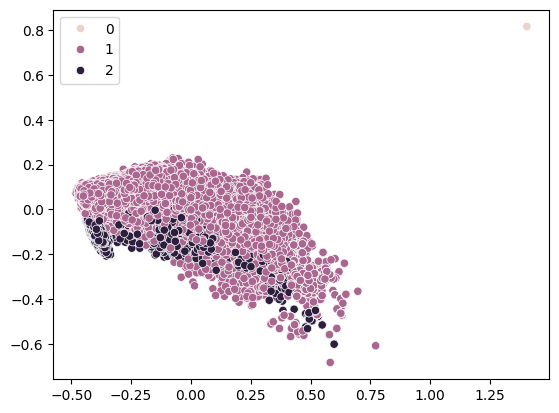

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
attn_transformed = pca.fit_transform(attn_filtered[idxs_under_investigation])

sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

<Axes: >

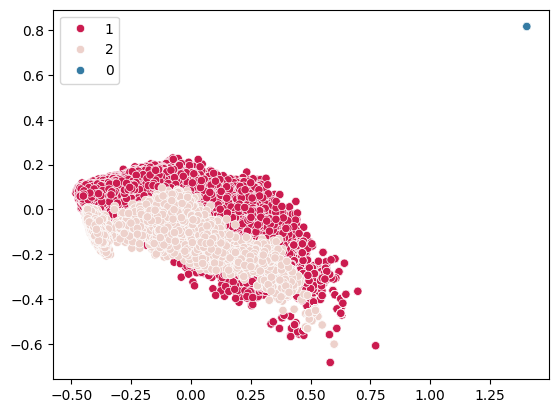

In [27]:
states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
zero_idx = np.where(np.array(states_under_investigation)==0)[0]
one_idx = np.where(np.array(states_under_investigation)==1)[0]
two_idx = np.where(np.array(states_under_investigation)==2)[0]
    
sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=np.array(states_under_investigation)[one_idx], palette="rocket")
sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=np.array(states_under_investigation)[two_idx])
sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=np.array(states_under_investigation)[zero_idx], palette="mako")

In [28]:
if DO_TSNE:
    from sklearn.manifold import TSNE
    tsne = TSNE()
    attn_transformed = tsne.fit_transform(attn_filtered[idxs_under_investigation])
    
    sns.scatterplot(x=attn_transformed[:, 0], y=attn_transformed[:, 1], hue=np.array(states_filtered)[idxs_under_investigation])

In [29]:
if DO_TSNE:
    states_under_investigation = np.array(states_filtered)[idxs_under_investigation]
    
    zero_idx = np.where(np.array(states_under_investigation)==0)[0]
    one_idx = np.where(np.array(states_under_investigation)==1)[0]
    two_idx = np.where(np.array(states_under_investigation)==2)[0]
    
    sns.scatterplot(x=attn_transformed[zero_idx, 0], y=attn_transformed[zero_idx, 1], hue=np.array(states_under_investigation)[zero_idx], palette="mako")
    sns.scatterplot(x=attn_transformed[one_idx, 0], y=attn_transformed[one_idx, 1], hue=np.array(states_under_investigation)[one_idx], palette="rocket")
    sns.scatterplot(x=attn_transformed[two_idx, 0], y=attn_transformed[two_idx, 1], hue=np.array(states_under_investigation)[two_idx])


## How does it generalize to shorter strings?

In [30]:
symbol_dict = {k: v for k, v in train_dataset.symbol_dict.items()}
symbol_dict["<SOS>"] = train_dataset.SOS
symbol_dict["<EOS>"] = train_dataset.EOS
symbol_dict["<PAD>"] = train_dataset.PAD

def encode_sequences(sequences: list, symbol_dict: dict, maxlen: int):
    """
    Encodes the sequences and returns a tensor. sequences is list of list.
    Shape of result: (len(sequences, maxlen+2)), with +2 for SOS and EOS

    => maxlen must be maximum length without SOS and EOS!!!
    """
    res = torch.ones((len(sequences), maxlen+2), dtype=torch.int64) * symbol_dict["<PAD>"]
    lengths = list()
    for i, seq in enumerate(sequences):
        lengths.append(len(seq)+2) # plus 2 for SOS, EOS
        res[i, 0] = symbol_dict["<SOS>"]
        for j, symbol in enumerate(seq):
            res[i, j+1] = symbol_dict[symbol]
        res[i, j+2] = symbol_dict["<EOS>"]
    return res, lengths
symbol_dict

{'a': 0,
 'k': 1,
 'd': 2,
 'l': 3,
 'e': 4,
 'm': 5,
 'o': 6,
 'b': 7,
 'p': 8,
 'i': 9,
 'n': 10,
 'j': 11,
 'h': 12,
 'c': 13,
 'f': 14,
 'g': 15,
 '<SOS>': 16,
 '<EOS>': 17,
 '<PAD>': 18}

In [31]:
int_to_char_map = {v: k for k, v in symbol_dict.items()}

def map_to_chars(sequences, int_to_char_map):
    for i, seq in enumerate(sequences):
        for j, s in enumerate(seq):
            sequences[i][j] = int_to_char_map[s]
    return sequences

In [49]:
sequences = [
    [0],
    [7],
    [0, 7],
    [0, 7, 7],
    [0, 1, 1, 1],
    [0, 6, 5, 2],
    [0, 11],
    [0, 4, 9],
    [0, 1, 1, 1, 7],
    [1], 
    [1, 7],
    [1, 0, 7]
]

encoded_s = map_to_chars(sequences, int_to_char_map)
x_input, lengths = encode_sequences(encoded_s, symbol_dict, MAX_STRING_LENGTH)
x_mask = make_tensor_causal_masks(x_input)

test_predictions = None

with torch.no_grad():
    outputs = model(**get_forward_dict(x_input, None, x_mask, output_attentions=True))
    print(list(outputs.logits.size()))
    
    preds = torch.zeros((len(lengths), 1))
    for i in range(x_input.size(0)):
        last_pos = torch.where(x_input[i] == EOS_TOKEN)[0][0]
        preds[i] = torch.argmax(outputs.logits[i, last_pos])
                
    # outputs.logits shape: (batch_size, seq_len, label_size)
    if(outputs.logits.size(-1) > PAD_TOKEN + 1):
        preds = preds - PAD_TOKEN - 1

    if test_predictions is None:
        test_predictions = preds.numpy()
        print(test_predictions.shape)
    else:
        test_predictions = np.concatenate((test_predictions, preds.numpy()), axis=-1)

encoded_s, test_predictions, train_dataset.label_dict # F.softmax(outputs.logits, dim=1), train_dataset.label_dict

[12, 31, 21]
(12, 1)


([['a'],
  ['b'],
  ['a', 'b'],
  ['a', 'b', 'b'],
  ['a', 'k', 'k', 'k'],
  ['a', 'o', 'm', 'd'],
  ['a', 'j'],
  ['a', 'e', 'i'],
  ['a', 'k', 'k', 'k', 'b'],
  ['k'],
  ['k', 'b'],
  ['k', 'a', 'b']],
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32),
 {'A': 0, 'R': 1})